In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date')
d_f=pd.read_csv('data_BTS2.csv',index_col='Date')

In [7]:
d_f

,Adj Close
Date,
2017-11-09,0.082825
2017-11-10,0.074902
2017-11-11,0.082099
2017-11-12,0.079113
2017-11-13,0.081149
...,...
2023-09-28,0.009200
2023-09-29,0.009185
2023-09-30,0.009170


In [4]:
df.head()

,Production
Date,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


<Axes: xlabel='Date'>

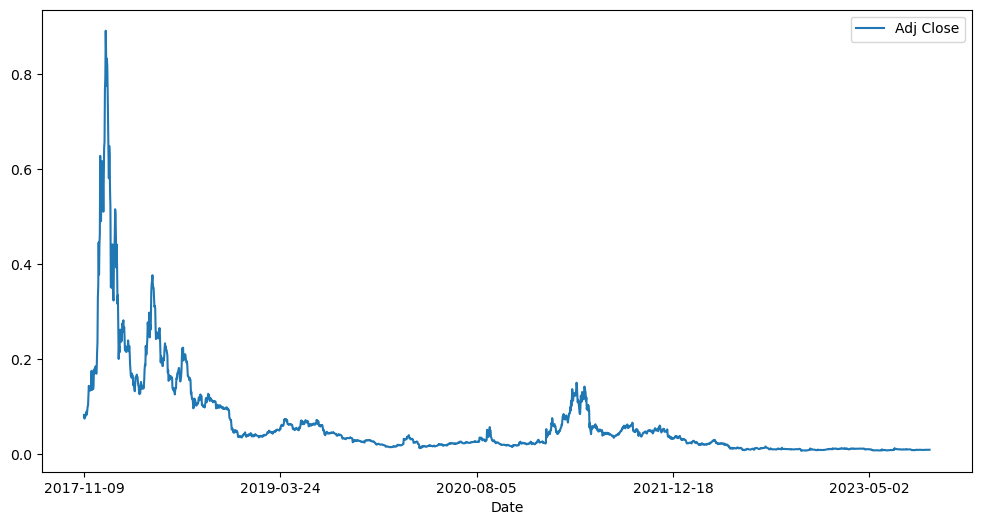

In [8]:
d_f.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
results = seasonal_decompose(d_f['Adj Close'])
results.plot();

NameError: name 'seasonal_decompose' is not defined

In [12]:
len(d_f)

2154

In [42]:
train = d_f.iloc[:2142]
test = d_f.iloc[2142:]

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [44]:
d_f.head(),d_f.tail()

(            Adj Close
 Date                 
 2017-11-09   0.082825
 2017-11-10   0.074902
 2017-11-11   0.082099
 2017-11-12   0.079113
 2017-11-13   0.081149,
             Adj Close
 Date                 
 2023-09-28   0.009200
 2023-09-29   0.009185
 2023-09-30   0.009170
 2023-10-01   0.009322
 2023-10-02   0.009293)

In [45]:
scaler.fit(train)
scaled_train = scaler.transform(train)
#scaled_test = scaler.transform(test)
train

,Adj Close
Date,
2017-11-09,0.082825
2017-11-10,0.074902
2017-11-11,0.082099
2017-11-12,0.079113
2017-11-13,0.081149
...,...
2023-09-16,0.009033
2023-09-17,0.009019
2023-09-18,0.008998


In [46]:
scaled_train[:10]

array([[0.08550446],
       [0.07654903],
       [0.08468386],
       [0.08130876],
       [0.08361007],
       [0.08655678],
       [0.09307753],
       [0.08612274],
       [0.09640177],
       [0.10531878]])

In [47]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [48]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [49]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08550446 0.07654903 0.08468386]
Predict this y: 
 [[0.08130876]]


In [50]:
X.shape

(1, 3, 1)

In [51]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [53]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
2130/2130 [==============================] - 12s 5ms/step - loss: 0.0014
Epoch 2/50
2130/2130 [==============================] - 11s 5ms/step - loss: 6.0333e-04
Epoch 3/50
2130/2130 [==============================] - 11s 5ms/step - loss: 4.9925e-04
Epoch 4/50
2130/2130 [==============================] - 11s 5ms/step - loss: 4.5946e-04
Epoch 5/50
2130/2130 [==============================] - 11s 5ms/step - loss: 3.4011e-04
Epoch 6/50
2130/2130 [==============================] - 11s 5ms/step - loss: 3.3146e-04
Epoch 7/50
2130/2130 [==============================] - 11s 5ms/step - loss: 3.3468e-04
Epoch 8/50
2130/2130 [==============================] - 12s 6ms/step - loss: 3.0618e-04
Epoch 9/50
2130/2130 [==============================] - 12s 5ms/step - loss: 3.2069e-04
Epoch 10/50
2130/2130 [==============================] - 11s 5ms/step - loss: 2.7249e-04
Epoch 11/50
2130/2130 [==============================] - 12s 5ms/step - loss: 2.6988e-04
Epoch 12/50
2130/2130 [===========

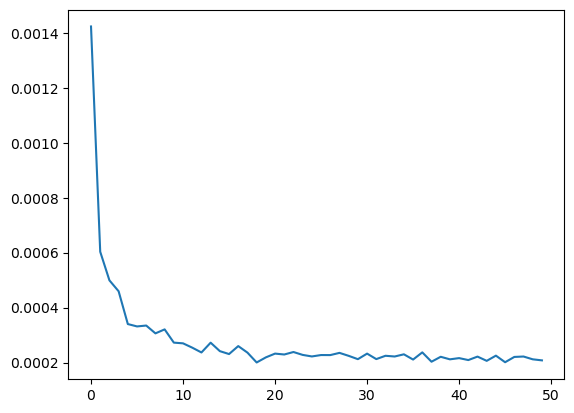

In [56]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [57]:
last_train_batch = scaled_train[-12:]

In [58]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [59]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 170ms/step


array([[0.0023417]], dtype=float32)

In [60]:
scaled_test[0]

NameError: name 'scaled_test' is not defined

In [61]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [62]:
test_predictions

[array([0.0023417], dtype=float32),
 array([0.00248851], dtype=float32),
 array([0.0025845], dtype=float32),
 array([0.0026629], dtype=float32),
 array([0.00272922], dtype=float32),
 array([0.00278583], dtype=float32),
 array([0.00283411], dtype=float32),
 array([0.00287564], dtype=float32),
 array([0.00291167], dtype=float32),
 array([0.00294286], dtype=float32),
 array([0.00296941], dtype=float32),
 array([0.00299191], dtype=float32)]

In [63]:
test.head()

,Adj Close
Date,
2023-09-21,0.008756
2023-09-22,0.008967
2023-09-23,0.009145
2023-09-24,0.009326
2023-09-25,0.009155


In [64]:
true_predictions = scaler.inverse_transform(test_predictions)

In [65]:
test['Predictions'] = true_predictions

C:\Users\DODZ\AppData\Local\Temp\ipykernel_24724\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

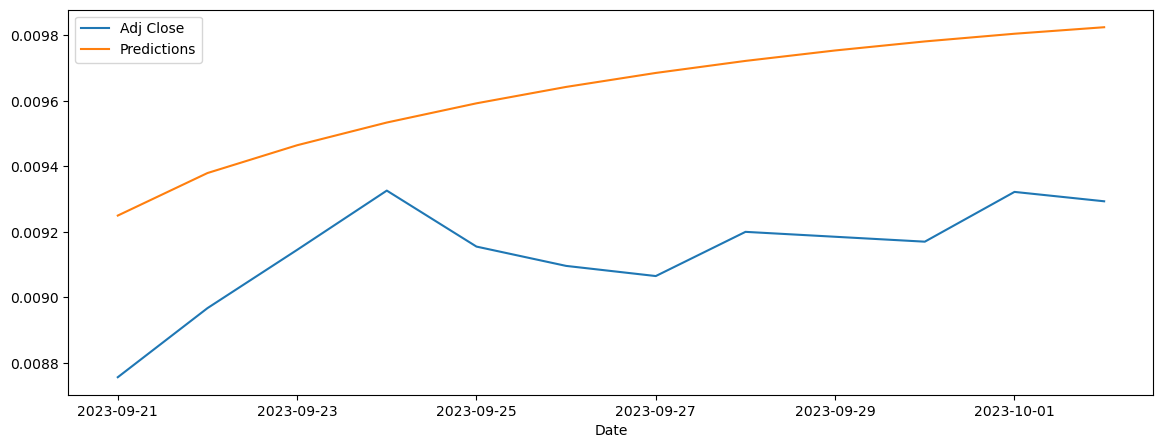

In [66]:
test.plot(figsize=(14,5))

In [69]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Adj Close'],test['Predictions']))
print(rmse)

0.0004933694412080341
